In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score 

## Discretising the data
To reduce the computational load of the problem, we have only taken data at every 1% strain step instead of all the timesteps run by the FE Simulation. The snippet below inputs the data file and looks for timesteps with 1% increment in effective strain and stores them

In [2]:
out_file = pd.read_csv('data/AR1/out.csv')
lim = 0.01
timesteps = []
time = []
for i in range(len(out_file)):
    if(out_file["eff_strain"][i] > lim):
        timesteps.append(i+1)
        time.append(out_file["time"][i])
        lim = lim + 0.01
steps = np.ceil((np.array(timesteps)/50))

## Reading and normalsing data
The data dumped by the seacas-exodus script is read here. We are only interested in 5 variables
- elem_x: x coordinate of every element
- elem_y: y coordinate of every element
- phases: phase the element belongs to
- strain_yy: the effective applied strain at that timestep
- eff_strain: the effective strain of the element, our only output variable

The rest of the variables are dropped and the variables of choice are normalised between 1 and -1

In [4]:
df = pd.read_csv('data/AR1/out_soudip.csv')
#df = df[df["time"].isin(steps)] 
df = df.drop(columns=['pressure', 'sdv22', 'sdv23', 'total_strain_xy', 'time', 'elem_id', 'blk_id', 
                      'total_stress_xx', 'total_stress_yy','total_strain_xx', 'total_strain_yy', 
                      'vonmises', 'triaxiality'' ])
df_norm = 2*(df-df.min())/(df.max()-df.min()) - 1
df_norm.tail()

,eff_strain,strain_yy,triaxiality,vonmises,elem_x,elem_y,phases
21279995,-0.790890,1.0,-0.224296,0.862288,0.017544,-0.017544,1.0
21279996,-0.752572,1.0,-0.241038,0.867445,0.017544,-0.012531,1.0
21279997,-0.625095,1.0,-0.256846,0.884972,0.022556,-0.032581,1.0
21279998,-0.709951,1.0,-0.229314,0.880816,0.022556,-0.027569,1.0
21279999,-0.712791,1.0,-0.256271,0.879132,0.022556,-0.022556,1.0


## Creating a directory
A directory is created for storing the trained model and all the related plots. The trained model can be loaded again for future use.

In [6]:
model_number = 94 # soudip data 0 to 1 with bias
base_path = './trained_models/model_%i' % (model_number)
os.mkdir(base_path)

## Separating data
Data is split randomly into 80% training data and 20% testing. The model is only shown the training data from which the learns the optimal weights and is tested on the rest 20% data.

In [ ]:
# Separating data in test and train
train_dataset = df_norm.sample(frac=0.8,random_state=0)
test_dataset = df_norm.drop(train_dataset.index)
train_stats = train_dataset.astype(float).describe(include='all')

train_labels = train_dataset[['eff_strain']].copy()
train_dataset = train_dataset.drop(columns=['eff_strain'])
test_labels = test_dataset[['eff_strain']].copy()
test_dataset = test_dataset.drop(columns=['eff_strain'])

norm_train_labels = train_labels
norm_test_labels = test_labels

norm_train_dataset = train_dataset
norm_test_dataset = test_dataset
norm_train_dataset.tail()

## Model Architecture
The architecture of our artificial neural network is defined here. We have 4 inputs and 1 output layer with 7 hidden layers shown in the example below. The number of hidden layers can be varied depending on whatever works best. 

In [ ]:
# Defining our model
def get_compiled_model():
    inputs = tf.keras.Input(shape=(4,))
    dense = tf.keras.layers.Dense(128, activation='relu', use_bias="True")
    x = dense(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', use_bias="True")(x)
    x = tf.keras.layers.Dense(32, activation='relu', use_bias="True")(x)
    x = tf.keras.layers.Dense(16, activation='relu', use_bias="True")(x)
    x = tf.keras.layers.Dense(8, activation='relu', use_bias="True")(x)
    x = tf.keras.layers.Dense(4, activation='relu', use_bias="True")(x)
    x = tf.keras.layers.Dense(2, activation='relu', use_bias="True")(x)
    #x = tf.keras.layers.Dense(2, activation='relu', use_bias="True")(x)
    outputs = tf.keras.layers.Dense(1, use_bias="True")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="first_model")
    tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)
    model.compile(optimizer='SGD',
                loss='mse',
                metrics=['accuracy', 'mse', 'mae', 'mean_absolute_percentage_error'])
    return model

## Model Training
The model is given the training data and number of epochs after which it starts training. The model is saved in the directory defined above. 

In [ ]:
model = get_compiled_model()
EPOCHS = 3

history = model.fit(norm_train_dataset, norm_train_labels, epochs=EPOCHS, batch_size=1)
print("Evaluate on test data")
results = model.evaluate(test_dataset, test_labels)
print("test loss, test acc:", results)
model.save(base_path+'/the_model')

## Model summary
The summary of the model is stored in a text file to easily identify the model for future uses.

In [ ]:
with open(base_path + '/model_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

## Plot of FE Values vs ANN Predictions
A plot of FE Values vs ANN Predctions on the test dataset is drawn on the same scale and it's fit along the y=x is observed. R^2 values are also computed for the given prediction and depicted on the graph. The closer the value of R^2 is to 1, the better the fit is.

In [ ]:
pred_label = norm_test_dataset
test_predictions = model.predict(norm_test_dataset)

pred_x = []
pred_y = []
pred_z = []
for y in test_predictions:
    pred_x.append(x)
len(pred_x)

pred_x_scaled = (pred_x + 1)*(df['eff_strain'].max() - df['eff_strain'].min())/2 + df['eff_strain'].min()
test_labels_scaled = (norm_test_labels['eff_strain'] + 1)*(df['eff_strain'].max() - df['eff_strain'].min())/2 + df['eff_strain'].min()
r2 = r2_score(test_labels_scaled, pred_x_scaled)
plt.figure()
a = plt.axes(aspect='equal')
a.text(0.,0.9, "$R^2$ = %0.2f"%(r2), fontsize=15)
plt.scatter(test_labels_scaled, pred_x_scaled, s=0.01)
x = [0,1]
y = x
plt.plot(x,y, 'r')
plt.title('$\epsilon_{eff}$')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.savefig(base_path+"/strain_eff_pred_exp.eps", format="eps")

## Preparing data for contour plots
The data used here has been randomly split into training and testing so that the model generalises well over every timestep. However we want to plot the contour map of effective strain at the last timestep for this model. The last timestep predictions are made below and the data is structured into a 400\*400 array to plot the 2D contour.

In [18]:
plot_df = df_norm.loc[df_norm['strain_yy']>0.996012]
plot_df = plot_df.sort_values(by=['elem_x', 'elem_y'])

last_step = df_norm.loc[df_norm['strain_yy']>0.996012]
train_last = plot_df.drop(columns=['eff_strain', 'vonmises', 'triaxiality'])
pred_last = model.predict(train_last)
label_last = plot_df[['eff_strain']].copy()
pred_last_scaled = (pred_last + 1)*(df['eff_strain'].max() - df['eff_strain'].min())/2 + df['eff_strain'].min()
label_last_scaled = (label_last + 1)*(df['eff_strain'].max() - df['eff_strain'].min())/2 + df['eff_strain'].min()
plot_pred_last = (np.asarray(pred_last_scaled)).reshape(400,400)
plot_label_last = (np.asarray(label_last_scaled)).reshape(400,400)

train_last

,eff_strain,strain_yy,triaxiality,vonmises,elem_x,elem_y,phases
21279833,0.052396,0.148487,0.131302,2256.450933,50.875,49.125,1
21279834,0.062101,0.148487,0.067747,2262.942924,50.875,49.375,1
21279835,0.094291,0.148487,0.006537,2284.566033,51.125,48.375,1
21279836,0.072573,0.148487,0.114299,2279.209113,51.125,48.625,1
21279837,0.071899,0.148487,0.010638,2277.119519,51.125,48.875,1


## Contour Plots
Three countour plots have been shown here:

- FE Values: True Effective strain values as computed by the FE simulations at the last time step
- ANN Values: Predicted Effective strain values as computed by the FE simulations at the last time step
- Error values: Difference between the FE values and ANN values for every element.

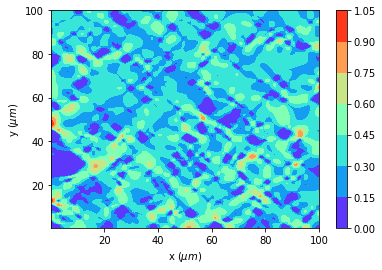

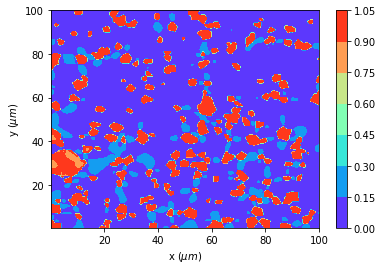

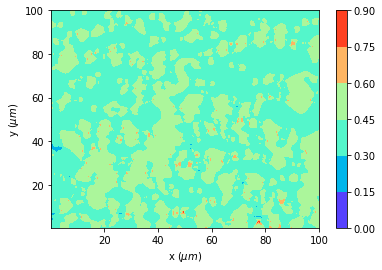

In [19]:
# Experimental values contours
plot_df = df_norm.loc[df_norm['strain_yy']>0.996012]
xlist = np.arange(0.25, 50, 0.5)
plot_df = plot_df.sort_values(by=['elem_x', 'elem_y'])

var_name = 'eff_strain'
plot_z = plot_label_last
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_z
fig,ax=plt.subplots(1,1)
mycmap1 = plt.get_cmap('rainbow')
cp_xx = ax.contourf(X, Y, Z, cmap=mycmap1)
fig.colorbar(cp_xx) # Add a colorbar to a plot
#ax.set_title('CPFE $\epsilon_{eff}$ At Final Time-step')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_exp_strain_eff.eps', format="eps")
xx_levels = cp_xx.levels

var_name = 'eff_strain'
#plot_z_scaled = np.array((plot_df[var_name]*(df[var_name].max() - df[var_name].min())) + df[var_name].min())
#plot_z = plot_z_scaled.reshape(400,400)
plot_z = plot_pred_last
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_z
fig,ax=plt.subplots(1,1)
mycmap1 = plt.get_cmap('rainbow')
cp_xx = ax.contourf(X, Y, Z, cmap=mycmap1, levels= xx_levels)
fig.colorbar(cp_xx) # Add a colorbar to a plot
#ax.set_title('CPFE $\epsilon_{eff}$ At Final Time-step')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_pred_strain_eff.eps', format="eps")
xx_levels = cp_xx.levels

var_name = 'eff_strain'
#plot_z_scaled = np.array((plot_df[var_name]*(df[var_name].max() - df[var_name].min())) + df[var_name].min())
#plot_z = plot_z_scaled.reshape(400,400)
plot_z = plot_pred_last - plot_label_last
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_z
fig,ax=plt.subplots(1,1)
mycmap1 = plt.get_cmap('rainbow')
cp_xx = ax.contourf(X, Y, Z, cmap=mycmap1)
fig.colorbar(cp_xx) # Add a colorbar to a plot
#ax.set_title('CPFE $\epsilon_{eff}$ At Final Time-step')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_error_strain_eff.eps', format="eps")
xx_levels = cp_xx.levels